# Projeto: Análise de Crédito
O objetivo desse projeto é aplicar um modelo de classificação para simular uma análise de crédito a partir de um conjunto de dados de agências de bancárias encontrado no Kaggle.

Dataset: https://www.kaggle.com/datasets/laotse/credit-risk-dataset

Participantes:
- Carlos Silva - https://github.com/CarlosSilva8
- Maria Raquel - https://github.com/mariaraquelbarbosa

# Sumário
- ### 1. Leitura e entendimento da base
- ### 2. Análise exploratória
- ### 3. Pré-Processamento dos dados
- ### 4. Modelagem
      4.1. Comparação de modelos de classificação com pycaret
      4.2. LightGBM Classifier
- ### 5. Tunagem de hiperparâmetros
- ### 6. Conclusão

# 1. Leitura e entendimento da base

In [ ]:
# Instalando bibliotecas
!pip install scikit-optimize
!pip install tpot
!pip install pycaret

In [2]:
# Imports
# Bibliotecas básicas:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import pandas as pd

# Pré-processamento:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modelagem e tunagem:
from pycaret.classification import *
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Avaliação do modelo:
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score,  roc_auc_score

Mounted at /content/drive


In [4]:
# Leitura da base
df = pd.read_csv("/content/drive/MyDrive/Projeto/Análise de Crédito/credit_risk_dataset.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


## Descrição das variáveis
- person_age - Idade
- person_income - Renda
- person_home_ownership - Estado de propriedade da casa
- person_emp_length - Tempo empregado (em anos)
- loan_intent - Motivo do empréstimo
- loan_grade - Nota do empréstimo
- loan_amnt - Valor do empréstimo
- loan_int_rate - Taxa de juros do empréstimo
- loan_status - Se a pessoa é ou não é inadimplente (0 se não é, 1 se é) - **variável target**
- loan_percent_income - Porcentagem do empréstimo em relação à renda
- cb_person_default_on_file - Se tem histórico de inadimplência
- cb_person_cred_hist_length - Tempo de histórico de crédito
  - O tempo de histórico de crédito refere-se à duração do período em que uma pessoa ou empresa possui um histórico de crédito registrado.


In [5]:
# Verificando dismensões do df
df.shape

(32581, 12)

In [6]:
# Verificando tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#2. Análise Exploratória

In [7]:
# Separando o df entre
df_indadimplente = df[(df['loan_status']== 1)]
df_naoindadimplente = df[(df['loan_status']== 0)]

In [8]:
# Resumo estatístico da base filtrando os clientes inadimplentes
df_indadimplente.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,7108.000000,7108.000000,6826.000000,7108.000000,6464.000000,7108.0,7108.000000,7108.000000
mean,27.474676,49125.652223,4.137562,10850.502954,13.060207,1.0,0.246889,5.685003
std,6.263642,36907.376527,4.126956,7143.345344,3.293167,0.0,0.132148,4.103208
min,20.000000,4000.000000,0.000000,900.000000,5.420000,1.0,0.010000,2.000000
25%,23.000000,30000.000000,1.000000,5000.000000,10.740000,1.0,0.140000,3.000000
50%,26.000000,41498.000000,3.000000,9600.000000,13.490000,1.0,0.240000,4.000000
75%,30.000000,59497.750000,6.000000,15000.000000,15.580000,1.0,0.340000,8.000000
max,70.000000,703800.000000,123.000000,35000.000000,23.220000,1.0,0.780000,30.000000


In [9]:
# Resumo estatístico da base filtrando os clientes não inadimplentes
df_naoindadimplente.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,25473.000000,2.547300e+04,24860.000000,25473.000000,23001.000000,25473.0,25473.000000,25473.000000
mean,27.807129,7.080436e+04,4.968745,9237.464178,10.435999,0.0,0.148805,5.837475
std,6.369669,6.656880e+04,4.129022,6026.375457,2.982190,0.0,0.087252,4.040900
min,20.000000,7.000000e+03,0.000000,500.000000,5.420000,0.0,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.680000,0.0,0.080000,3.000000
50%,26.000000,6.000000e+04,4.000000,8000.000000,10.590000,0.0,0.130000,4.000000
75%,30.000000,8.400000e+04,7.000000,12000.000000,12.690000,0.0,0.200000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,22.060000,0.0,0.830000,30.000000


A partir da análise estatística da base de clientes indadimplemente e adimplentes, foi possível observar que não há um desequilíbrio significativo entre as classes, já que a base minoritária representa mais de 10% da base (no caso, temos 22% de clientes indadimplentes e 78% de clientes adimplentes). Além disso, outros pontos que podemos mencionar é que a renda média da base de clientes adimplentes é maior que a de clientes inadimplentes e o montante do crédito é menor, assim como a taxa de juros do empréstimo. Assim, é nitidamente possível identificar uma situação mais favorável para que esses clientes cumprissem com suas obrigações financeiras.

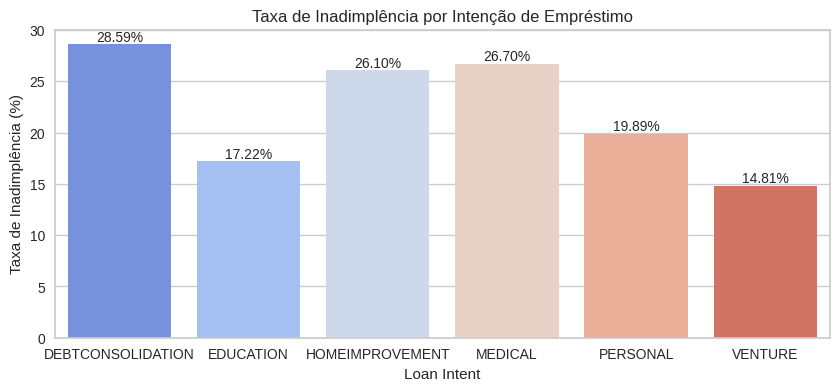

In [23]:
# Calculando a razão de inadimplentes por categoria
share_inadimplentes = df[df['loan_status'] == 1].groupby('loan_intent').size() / df.groupby('loan_intent').size() * 100

# Criando o gráfico de barras com cores diferentes para cada barra
plt.figure(figsize=(10, 4))
sns.barplot(x=share_inadimplentes.index, y=share_inadimplentes, palette='coolwarm')

# Ajustando o layout
plt.xlabel('Loan Intent')
plt.ylabel('Taxa de Inadimplência (%)')
plt.title('Taxa de Inadimplência por Intenção de Empréstimo')

# Adicionando rótulos nas barras
for index, value in enumerate(share_inadimplentes):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

É possível analisar que há uma maior taxa de inadimplência no caso dos clientes que solicitam crédito com a intenção de consolidar outras dívidas, para fins médicos e para a realização de reformas ou reparos na residência.

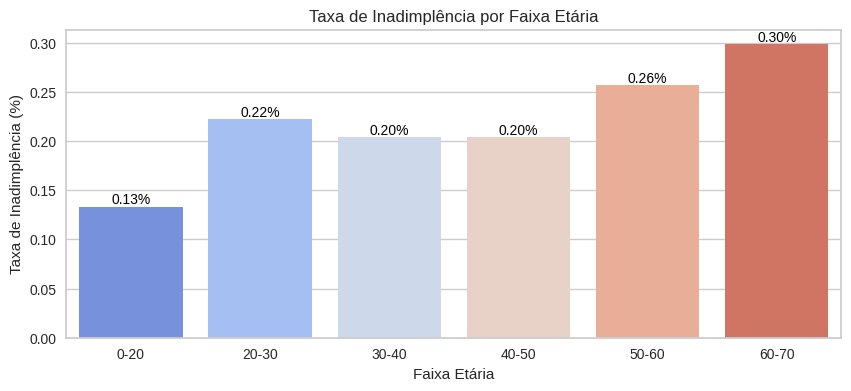

In [26]:
# Definindo as faixas etárias desejadas
faixas_etarias = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70']

# Criando as faixas etárias com base nas idades
df['Faixa Etária'] = pd.cut(df['person_age'], bins=[0, 20, 30, 40, 50, 60, 70], labels=faixas_etarias)

# Filtrando os dados para pegar faixas etárias até 70 anos
df_filtered = df[df['person_age'] <= 70]

# Calculando a razão de inadimplentes por faixa etária
df_grouped = df_filtered.groupby('Faixa Etária')['loan_status'].apply(lambda x: (x == 1).sum() / len(x)).reset_index()

# Criando o gráfico de barras
plt.figure(figsize=(10, 4))
sns.barplot(x='Faixa Etária', y='loan_status', data=df_grouped, palette='coolwarm')

# Definindo os rótulos nos dados
for index, value in enumerate(df_grouped['loan_status']):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Ajustando o layout
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Inadimplência (%)')
plt.title('Taxa de Inadimplência por Faixa Etária')
plt.show()

A partir da análise da taxa de inadimplência dividida por faixa etária, é possível observar que há uma maior tendência de inadimplência no caso de clientes acima de 60 anos, o que pode estar relacionado a diversos fatores, como um valor de aposentadoria insuficiente para cumprir com suas despesas e obrigações, um aumento significativo nos gastos com despesas médicas, empréstimos acumulados ao longo da vida, entre outros.

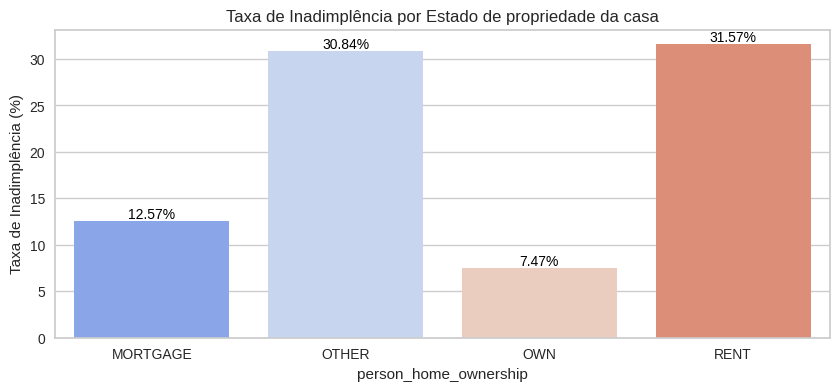

In [29]:
# Calculando a razão de inadimplentes por categoria
share_inadimplentes = df[df['loan_status'] == 1].groupby('person_home_ownership').size() / df.groupby('person_home_ownership').size()

# Criando o gráfico de barras
plt.figure(figsize=(10, 4))
colors = sns.color_palette('coolwarm', n_colors=len(share_inadimplentes))  # Utilizando a paleta 'coolwarm' para as cores
bars = sns.barplot(x=share_inadimplentes.index, y=share_inadimplentes * 100, palette=colors)

# Definindo os rótulos nos dados
for bar, value in zip(bars.patches, share_inadimplentes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Ajustando o layout
plt.xlabel('person_home_ownership')
plt.ylabel('Taxa de Inadimplência (%)')
plt.title('Taxa de Inadimplência por Estado de propriedade da casa')
plt.show()

Além disso, observa-se que as pessoas que pagam aluguel apresentam uma maior tendência de inadimplência do que pessoas que possuem casa própria ou que realizam empréstimo hipotecário. Isso pode ocorrer por uma série de motivos, como o fato das pessoas que pagam aluguel, em geral, terem uma menor renda disponível para cumprir outras obrigações financeiras além do aluguel, não terem um ativo tangível que possa servir como garantia ou facilitar a negociação e o acesso ao crédito, ou ainda podem ter menos estabilidade financeira em comparação com aquelas que possuem casa própria.

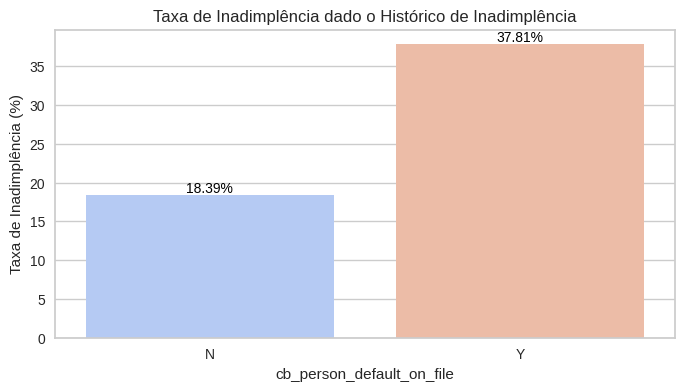

In [31]:
# Calculando a razão de inadimplentes por categoria
share_inadimplentes = df[df['loan_status'] == 1].groupby('cb_person_default_on_file').size() / df.groupby('cb_person_default_on_file').size()

# Criando o gráfico de barras
plt.figure(figsize=(8, 4))
colors = sns.color_palette('coolwarm', n_colors=len(share_inadimplentes))  # Utilizando a paleta 'coolwarm' para as cores
bars = sns.barplot(x=share_inadimplentes.index, y=share_inadimplentes * 100, palette=colors)

# Definindo os rótulos nos dados
for bar, value in zip(bars.patches, share_inadimplentes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Ajustando o layout
plt.xlabel('cb_person_default_on_file')
plt.ylabel('Taxa de Inadimplência (%)')
plt.title('Taxa de Inadimplência dado o Histórico de Inadimplência')
plt.show()

A partir do gráfico acima, nota-se que as pessoas que já apresentavam um histórico de inadimplência têm uma maior tendência a tornarem-se inadimplentes novamente.

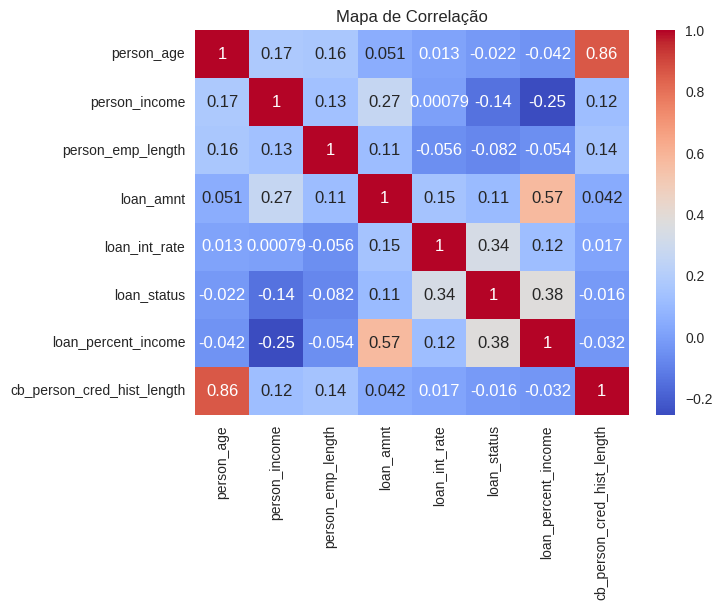

In [40]:
# Calculando a matriz de correlação
correlation_matrix = df.corr()

# Plotando o mapa de correlação
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.show()

Por fim, sobre a matriz de correlação, nota-se correlações de maior magnitude entre as variáveis person_age e cb_person_cred_hist_lenght, o que faz sentido devido ao fato de pessoas mais velhas terem uma maior tendência de acumular dívidas e solicitar empréstimos ao longo da vida, como também loan_amnt e loan_percent_income, o que também é intuitivo pelo fato de que, quanto maior o montante do crédito, maior será a sua representação em relação ao total de renda da pessoa. Porém, é importante pontuar que a ocorrência de correlações fortes não é sempre necessária para a construção de um bom modelo de machine learning.

# 3. Pré-processamento

In [ ]:
# Verificando valores faltantes
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
Faixa Etária                    13
dtype: int64

In [ ]:
# Removendo linhas com valores faltantes
df.dropna(inplace = True)

In [ ]:
# Verificando linhas duplicadas
duplicados = df.duplicated()
duplicados.sum()

137

In [ ]:
# Removendo linhas duplicadas
df.drop_duplicates(inplace = True)

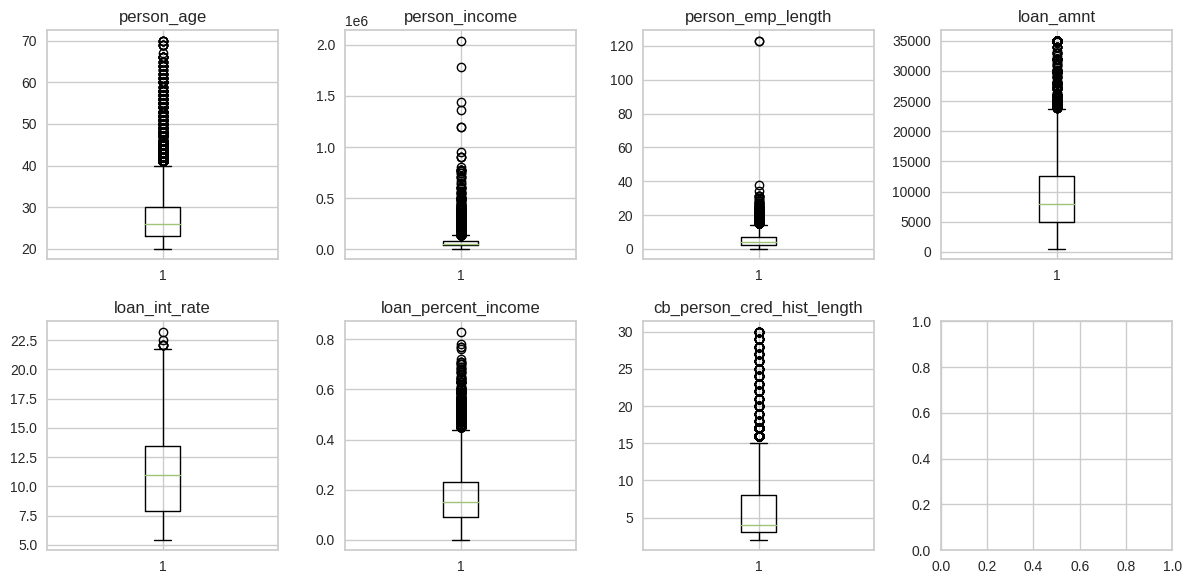

In [ ]:
# Selecionando as colunas desejadas
cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Criando a figura com subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Loop para adicionar cada boxplot
for i, col in enumerate(cols):
    # Plotando o boxplot no subplot correspondente
    ax = axs[i // 4, i % 4]
    ax.boxplot(df[col])
    ax.set_title(col)

# Ajustando o layout
plt.tight_layout()
plt.show()

In [ ]:
# Criando função para remover outliers
def removeoutlier(values):
    fator = 1.5
    q3, q1 = np.percentile(values, [75, 25])
    iqr = q3 - q1
    lowpass = q1 - (iqr * fator)
    highpass = q3 + (iqr * fator)
    filtered_values = []
    for v in values:
        if v > lowpass and v < highpass:
            filtered_values.append(v)
        else:
            filtered_values.append(float('nan'))
    return pd.Series(filtered_values)

In [ ]:
# Aplicando a função
df[['person_age', 'person_income', 'person_emp_length']] = df[['person_age', 'person_income', 'person_emp_length']].apply(removeoutlier)

In [ ]:
# Criando função para normalizar os dados do df
def normalize_data(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_normalized

In [ ]:
# Verificando os valores únicos de cada coluna categórica
print(df['loan_intent'].unique())
print(df['person_home_ownership'].unique())
print(df['loan_grade'].unique())
print(df['cb_person_default_on_file'].unique())

['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['D' 'B' 'C' 'A' 'E' 'F' 'G']
['Y' 'N']


In [ ]:
# Criando variáveis dummies para representar os valors categóricos
df_dummies = pd.get_dummies(df[['loan_intent', 'person_home_ownership', 'loan_grade']])
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'Y' : 1,
                                                                           'N' : 0})
df = pd.concat([df, df_dummies], axis=1)

In [ ]:
# Excluindo as colunas com valores qualitativos
df = df.drop(df[['loan_intent', 'person_home_ownership', 'loan_grade']], axis=1)
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Faixa Etária,...,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22.0,59000.0,NaN,35000,16.02,1,0.59,1,3,20-30,...,0,0,1,0,0,0,1,0,0,0
1,21.0,9600.0,5.0,1000,11.14,0,0.10,0,2,20-30,...,0,1,0,0,1,0,0,0,0,0
2,25.0,9600.0,1.0,5500,12.87,1,0.57,0,3,20-30,...,0,0,0,0,0,1,0,0,0,0
3,23.0,65500.0,4.0,35000,15.23,1,0.53,0,2,20-30,...,0,0,1,0,0,1,0,0,0,0
4,24.0,54400.0,8.0,35000,14.27,1,0.55,1,4,20-30,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,NaN,NaN,NaN,5800,13.16,0,0.11,0,30,50-60,...,0,0,0,0,0,1,0,0,0,0
32577,NaN,NaN,NaN,17625,7.49,0,0.15,0,19,50-60,...,0,0,0,1,0,0,0,0,0,0
32578,NaN,NaN,NaN,35000,10.99,1,0.46,0,28,60-70,...,0,0,1,0,1,0,0,0,0,0
32579,NaN,NaN,NaN,15000,11.48,0,0.10,0,26,50-60,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Definindo um número máximo de colunas exibidas ao imprimir um df
pd.set_option('display.max_columns', 500)

In [ ]:
# Excluindo a coluna Faixa Etária (usada para melhor visualizar o gráfico)
df = df.drop(['Faixa Etária'], axis=1)

# Normaliando o df
normalize_data(df)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,0.10,0.403226,NaN,1.000000,0.595506,1.0,0.710843,1.0,0.035714,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.05,0.041056,0.357143,0.014493,0.321348,0.0,0.120482,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.25,0.041056,0.071429,0.144928,0.418539,1.0,0.686747,0.0,0.035714,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.15,0.450880,0.285714,1.000000,0.551124,1.0,0.638554,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.20,0.369501,0.571429,1.000000,0.497191,1.0,0.662651,1.0,0.071429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28486,NaN,NaN,NaN,0.153623,0.434831,0.0,0.132530,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28487,NaN,NaN,NaN,0.496377,0.116292,0.0,0.180723,0.0,0.607143,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28488,NaN,NaN,NaN,1.000000,0.312921,1.0,0.554217,0.0,0.928571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28489,NaN,NaN,NaN,0.420290,0.340449,0.0,0.120482,0.0,0.857143,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#4.Modelagem

##4.2. Comparação de modelos de classificação

In [ ]:
# Configurando o ambiente
setup(data=df, target='loan_status')

# Comparar modelos com validação cruzada
compare_models(fold=10)

,Description,Value
0,Session id,5428
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(28491, 26)"
4,Transformed data shape,"(28491, 26)"
5,Transformed train set shape,"(19943, 26)"
6,Transformed test set shape,"(8548, 26)"
7,Numeric features,25
8,Rows with missing values,22.0%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9156,0.9199,0.6758,0.9129,0.7765,0.7259,0.7385,0.6060
xgboost,Extreme Gradient Boosting,0.9132,0.9161,0.6781,0.8972,0.7722,0.7199,0.7308,3.0060
gbc,Gradient Boosting Classifier,0.9130,0.9143,0.6627,0.9128,0.7677,0.7158,0.7298,3.0300
rf,Random Forest Classifier,0.9097,0.9078,0.6523,0.9060,0.7583,0.7046,0.7191,3.0070
et,Extra Trees Classifier,0.8997,0.8928,0.6299,0.8730,0.7316,0.6719,0.6856,3.0180
ada,Ada Boost Classifier,0.8766,0.8856,0.5966,0.7838,0.6773,0.6028,0.6115,1.0610
lda,Linear Discriminant Analysis,0.8635,0.8673,0.5809,0.7352,0.6489,0.5656,0.5717,0.2450
ridge,Ridge Classifier,0.8594,0.0000,0.5103,0.7642,0.6118,0.5301,0.5463,0.2430
dt,Decision Tree Classifier,0.8588,0.8003,0.6968,0.6680,0.6820,0.5914,0.5917,0.2520
nb,Naive Bayes,0.8134,0.7680,0.3417,0.6306,0.4429,0.3425,0.3659,0.1950


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5428, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Criando e treinando o modelo
model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9133,0.9152,0.6674,0.9088,0.7696,0.7178,0.7307
1,0.9173,0.9351,0.7067,0.8895,0.7876,0.7371,0.7446
2,0.9133,0.9265,0.6728,0.9040,0.7715,0.7194,0.7313
3,0.9097,0.9131,0.6559,0.9016,0.7594,0.7055,0.7190
4,0.9208,0.9249,0.6928,0.9231,0.7916,0.7439,0.7555
5,0.9142,0.9225,0.6721,0.9094,0.7729,0.7215,0.7340
6,0.9233,0.9215,0.7113,0.9167,0.8010,0.7544,0.7638
7,0.9178,0.9204,0.6674,0.9353,0.7790,0.7302,0.7459
8,0.9097,0.9093,0.6467,0.9121,0.7568,0.7033,0.7190


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Calculando a importância das variáveis
importance = pd.DataFrame({'Feature': model.feature_name_, 'Importance': model.feature_importances_})
importance = importance.sort_values('Importance', ascending=False)
importance.reset_index(drop=True, inplace=True)
importance

,Feature,Importance
0,loan_amnt,565
1,loan_percent_income,509
2,loan_int_rate,410
3,person_income,286
4,person_age,156
5,cb_person_cred_hist_length,153
6,person_emp_length,138
7,person_home_ownership_OWN,103
8,person_home_ownership_RENT,96
9,loan_intent_HOMEIMPROVEMENT,81


In [ ]:
# Filtrando as variáveis "não dummies"
importance = importance.loc[0:6]

In [ ]:
# Calculando o valor do percentil 25
percentile_25 = importance['Importance'].quantile(0.25)

# Filtrando as variáveis abaixo do percentil 25
filtered_variables = importance[importance['Importance'] < percentile_25]
filtered_variables

,Feature,Importance
5,cb_person_cred_hist_length,153
6,person_emp_length,138


In [ ]:
# Removendo variáveis com pouca importância relativa no modelo
df = df.drop(['person_age', 'cb_person_cred_hist_length'], axis=1)

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,...,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,59000.0,NaN,35000,16.02,1,0.59,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,9600.0,5.0,1000,11.14,0,0.10,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,9600.0,1.0,5500,12.87,1,0.57,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,65500.0,4.0,35000,15.23,1,0.53,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,54400.0,8.0,35000,14.27,1,0.55,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,NaN,NaN,5800,13.16,0,0.11,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
32577,NaN,NaN,17625,7.49,0,0.15,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32578,NaN,NaN,35000,10.99,1,0.46,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
32579,NaN,NaN,15000,11.48,0,0.10,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


##4.2. LightGBM Classifier

In [ ]:
# Declarando as variáveis
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [ ]:
# Separando em dados de teste e dados de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Construindo o modelo LGBM
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# Prevendo os resultados
y_pred=clf.predict(X_test)

In [ ]:
# Checando acurácia
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9172905942910622


In [ ]:
# Testando o modelo na base de treino para verificar Overfitting
y_pred_train = clf.predict(X_train)
print('Training-set accuracy:', accuracy_score(y_train, y_pred_train))

Training-set accuracy: 0.9300506443363586


As acurácias do modelo aplicado à base de treino e à base de teste são próximas, o que indica que não houve overfitting.

<Axes: >

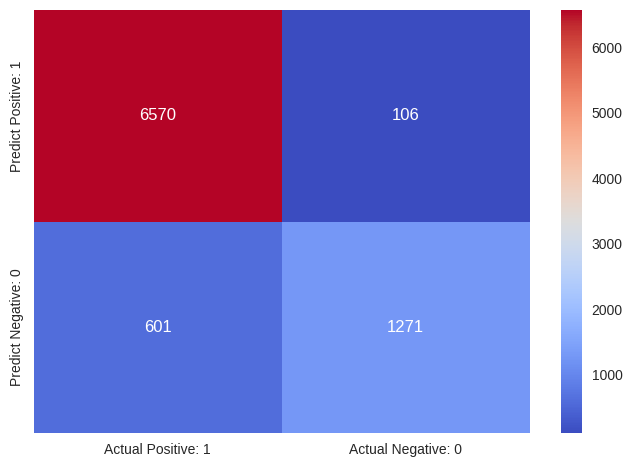

In [ ]:
# Plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive: 1', 'Actual Negative: 0'],
                                 index=['Predict Positive: 1', 'Predict Negative: 0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')

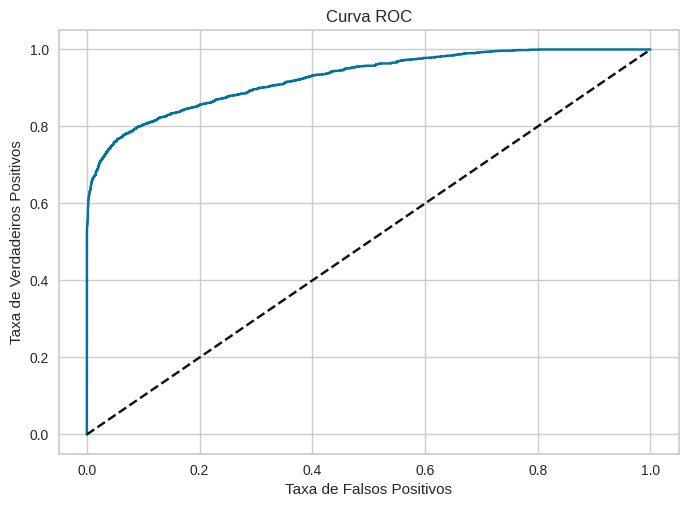

In [ ]:
# Calculando as probabilidades previstas pelo modelo
probs = clf.predict_proba(X_test)

# Pegando apenas as probabilidades da classe positiva
probs_positive = probs[:, 1]

# Calculando a taxa de falsos positivos, a taxa de verdadeiros positivos e os limiares
fpr, tpr, thresholds = roc_curve(y_test, probs_positive)

# Plotando a curva ROC
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.show()

In [ ]:
# Avaliando a precisão e o recall do modelo
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Precision 0.9230210602759622
Recall 0.6789529914529915
AUC: 0.83153761016628


#5. Tunagem de hiperparâmetros

In [ ]:
# Tunando o modelo com pycaret
model_tuned = tune_model(clf, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9125,0.9223,0.6674,0.9045,0.7681,0.7157,0.7283
1,0.9130,0.9190,0.6617,0.9139,0.7676,0.7158,0.7299
2,0.9128,0.9203,0.6667,0.9074,0.7686,0.7164,0.7293
3,0.9175,0.9165,0.6790,0.9202,0.7814,0.7320,0.7448
4,0.9125,0.9102,0.6478,0.9273,0.7627,0.7112,0.7283
Mean,0.9137,0.9177,0.6645,0.9147,0.7697,0.7182,0.7321
Std,0.0019,0.0042,0.0101,0.0083,0.0062,0.0071,0.0064


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# Definindo a grade de hiperparâmetros
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Definindo a estratégia de busca de hiperparâmetros
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)

# Treinando o modelo com diferentes combinações de hiperparâmetros
grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_

# Avaliando o desempenho do modelo com os melhores hiperparâmetros
best_score = grid_search.best_score_

# Treinando o modelo final com os melhores hiperparâmetros
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Prevendo os resultados
y_pred = final_model.predict(X_test)

<Axes: >

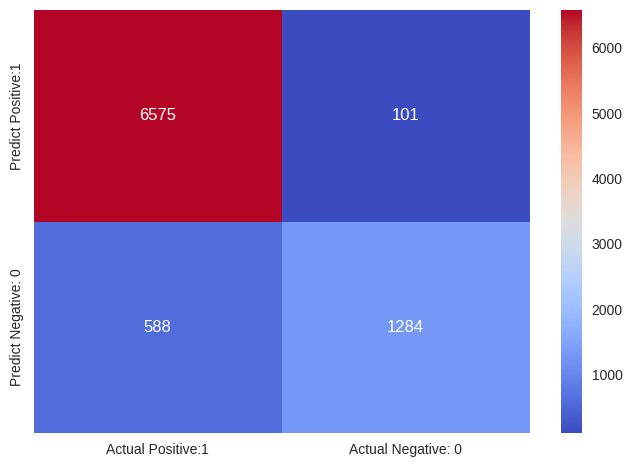

In [ ]:
# Plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative: 0'],
                                 index=['Predict Positive:1', 'Predict Negative: 0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')

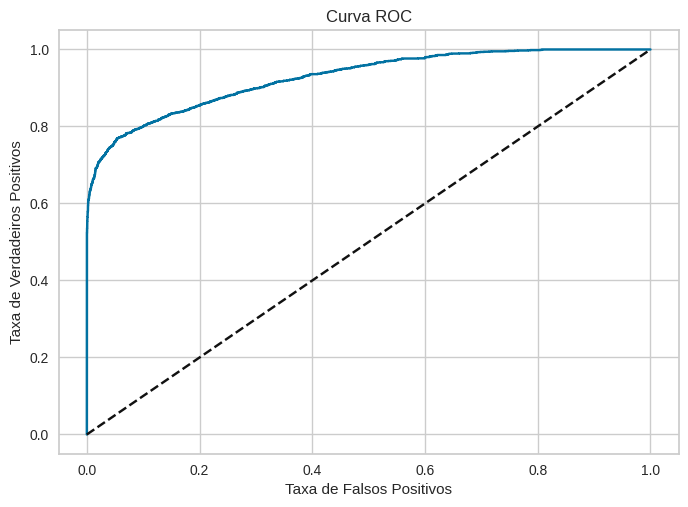

In [ ]:
# Calculando as probabilidades previstas pelo modelo
probs = final_model.predict_proba(X_test)

# Pegando apenas as probabilidades da classe positiva
probs_positive = probs[:, 1]

# Calculando a taxa de falsos positivos, a taxa de verdadeiros positivos e os limiares
fpr, tpr, thresholds = roc_curve(y_test, probs_positive)

# Plotando a curva ROC
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.show()

In [ ]:
# Avaliando a precisão e o recall do modelo tunado
print('Accuracy:', accuracy_score(y_pred, y_test))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.9193963500233973
Precision: 0.9270758122743682
Recall: 0.6858974358974359
AUC: 0.8353843081224748
